In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxa
from scipy import stats
from pyproj import Transformer

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]
netcdf_fps = '/bsuhome/zacharykeskinen/scratch/data/uavsar/images/vv_coherence'

data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv.pkl'), 'rb') as f:
    cor_vv = pickle.load(f)

In [2]:
def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

In [3]:
# lidar_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar'
# for d in glob(join(lidar_dir,'*')):
#     if 'taylor' in d:
#         pass
#     elif 'Lowman' in d:
#         for sf in glob(join(d, '*')):
#             for f in glob(join(sf, '*.tif')):
#                 subloc = basename(sf)
#                 date = basename(f).split('_')[-2]
#                 if '_SD_' in f or 'snowdepth' in f:
#                     sd = rxa.open_rasterio(f)
#                     sd_re = sd.rio.reproject_match(cor_vv['Lowman,_CO'])[0]
#                     cor_vv['Lowman,_CO'][f'{subloc}-{date}-sd'] = sd_re.where(sd_re < 1000)
#                 elif '_VH_' in f:
#                     veg = rxa.open_rasterio(f)
#                     veg_re = veg.rio.reproject_match(cor_vv['Lowman,_CO'])[0]
#                     cor_vv['Lowman,_CO'][f'{subloc}-{date}-veg'] = veg_re.where(veg_re < 1000)
#     else:
#         for f in glob(join(d, '*.tif')):
#             date = basename(f).split('_')[-2]
#             loc = basename(dirname(f))
#             if 'EastRiver' in f:
#                 date = '20200214'
#             if '_SD_' in f or 'snowdepth' in f:
#                 sd = rxa.open_rasterio(f)
#                 sd_re = sd.rio.reproject_match(cor_vv[loc])[0]
#                 cor_vv[loc][f'{date}-sd'] = sd_re.where(sd_re < 1000)
#             elif '_VH_' in f:
#                 veg = rxa.open_rasterio(f)
#                 veg_re = veg.rio.reproject_match(cor_vv[loc])[0]
#                 cor_vv[loc][f'{date}-veg'] = veg_re.where(veg_re < 1000)

In [4]:
lidar_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar'
for d in glob(join(lidar_dir,'*')):
    if 'taylor' in d:
        pass
    elif 'Lowman' in d:
        for sf in glob(join(d, '*')):
            for f in glob(join(sf, '*.tif')):
                subloc = basename(sf)
                date = basename(f).split('_')[-2]
                if '_SD_' in f or 'snowdepth' in f:
                    sd = rxa.open_rasterio(f)
                    sd_re = sd.rio.reproject_match(cor_vv['Lowman,_CO'])[0]
                    cor_vv['Lowman,_CO'][f'{subloc}-{date}-sd'] = sd_re.where(sd_re < 1000)
                elif '_VH_' in f:
                    veg = rxa.open_rasterio(f)
                    veg_re = veg.rio.reproject_match(cor_vv['Lowman,_CO'])[0]
                    cor_vv['Lowman,_CO'][f'{subloc}-{date}-veg'] = veg_re.where(veg_re < 1000)
    # else:
    #     for f in glob(join(d, '*.tif')):
    #         date = basename(f).split('_')[-2]
    #         loc = basename(dirname(f))
    #         if 'EastRiver' in f:
    #             date = '20200214'
    #         elif 'Grand' in f:
    #             date=basename(f).split('_')[-3].replace('Feb','02').replace('-2','')
                
    #         if '_SD_' in f or 'snowdepth' in f:
    #             sd = rxa.open_rasterio(f)
    #             sd_re = sd.rio.reproject_match(cor_vv[loc])[0]
    #             cor_vv[loc][f'{date}-sd'] = sd_re.where(sd_re < 1000)
    #         elif '_VH_' in f:
    #             veg = rxa.open_rasterio(f)
    #             veg_re = veg.rio.reproject_match(cor_vv[loc])[0]
    #             cor_vv[loc][f'{date}-veg'] = veg_re.where(veg_re < 1000)

CPLE_OutOfMemoryError: memdataset.cpp, 1246: cannot allocate 1x4017920160 bytes

In [ ]:
cor_vv['Grand_Mesa,_CO']

<xarray.Dataset>
Dimensions:      (y: 1242, x: 1825, band: 10)
Coordinates:
  * y            (y) float64 39.19 39.19 39.19 39.19 ... 38.93 38.93 38.93 38.93
  * x            (x) float64 -108.3 -108.3 -108.3 ... -107.9 -107.9 -107.9
    lon          (x) float64 -108.3 -108.3 -108.3 ... -107.9 -107.9 -107.9
    lat          (y) float64 39.19 39.19 39.19 39.19 ... 38.93 38.93 38.93 38.93
  * band         (band) <U38 'grmesa_27416_21017-017_21019-017_0006d' ... 'gr...
    spatial_ref  int64 0
Data variables:
    cor_vv       (band, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    274-inc      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    tree-height  (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 8 8 11 11 10 8 3 3 3 5 6
    tree-perc    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    biomass      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    USCOGM-veg   (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    20200213-sd  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    2020021-sd   (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  Coherence for VV over lowman

In [ ]:
data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv_2.pkl'), 'wb') as f:
    pickle.dump(cor_vv, f)

In [ ]:
sd_pairs = {'Rocky_Mountains_NP,_CO': {'20210319-sd':['rockmt_32109_21017-013_21021-001_0012d']}, 
'Fraser,_CO': {'20210319-sd':['fraser_05209_21020-025_21021-003_0006d','fraser_23306_21020-026_21021-004_0006d'],
'20200211-sd':['fraser_23307_20005-010_20008-007_0007d']},
'Grand_Mesa,_CO':{'20200213-sd':['grmesa_27416_20003-028_20005-007_0011d']},
'Peeler_Peak,_CO':{'20200214-sd':['peeler_31619_20005-006_20008-003_0007d']},
'Salt_Lake_City,_UT':{'20210318-sd':['stlake_27129_21020-024_21022-001_0006d','stlake_09127_21020-023_21022-000_0006d']},
'Lowman,_CO':
{'mores-20200209-sd':['lowman_23205_20007-003_20011-003_0008d'],
'mores-20210310-sd':['lowman_23205_21017-018_21019-018_0006d','lowman_05208_21017-019_21019-019_0006d'],
# {'mores-20210315-sd':'lowman_23205_21017-018_21019-018_0006d'},
'dry_creek-20200219-sd':['lowman_23205_20007-003_20011-003_0008d'],
'banner-20200218-sd':['lowman_23205_20007-003_20011-003_0008d'],
'banner-20210315-sd':['lowman_23205_21017-018_21019-018_0006d','lowman_05208_21017-019_21019-019_0006d']}}

In [ ]:
sds = []
cors = []
for loc, ds in cor_vv.items():
    sd_keys = [k for k in list(ds.keys()) if 'sd' in k]
    if len(sd_keys) > 0:
        for sd_key in sd_keys:
            try:
                pair = sd_pairs[loc][sd_key]
                for p in pair:
                    cor = cor_vv[loc].sel({'band':p})['cor_vv'].values.ravel()
                sd = cor_vv[loc][sd_key].values.ravel()
                cor, sd = clean_nps([cor, sd])
                sds.append(sd)
                cors.append(cor)
            except KeyError as e:
                pass
cors = np.concatenate(cors)
sds = np.concatenate(sds)

cors= cors[sds>0]
sds = sds[sds>0]

In [ ]:
slope, intercept,r,p, _, _ = r2_value(sds, cors)

slope: -0.004516576259851651. intercept: 0.5308944666955664. r_value -0.012414809726076954. p value: 2.36242330709984e-83


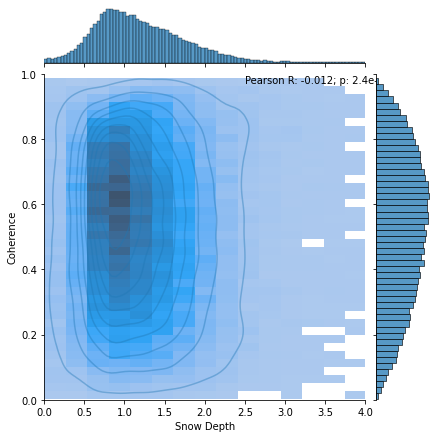

In [ ]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = sds[::50], y = cors[::50], kind = 'hist', bins = 40, ylim = (0,1), xlim = (0, 4))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [2.5,0.97])
g.ax_joint.set_xlabel('Snow Depth')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/snow-depth', 'all-sd.png'))

## Control for incidence angle, trees

In [ ]:
sds = []
cors = []
for loc, ds in cor_vv.items():
    sd_keys = [k for k in list(ds.keys()) if 'sd' in k]
    if len(sd_keys) > 0:
        for sd_key in sd_keys:
            try:
                pair = sd_pairs[loc][sd_key]
                for p in pair:
                    cor = cor_vv[loc].sel({'band':p})['cor_vv'].values.ravel()
                    sd = cor_vv[loc][sd_key].values.ravel()
                    dir = p.split('_')[1][:3]
                    inc = cor_vv[loc][f'{dir}-inc'].values.ravel()
                    trees = cor_vv[loc][f'tree-perc'].values.ravel()
                    cor, sd, inc, trees = clean_nps([cor, sd, inc, trees])
                    cond = (inc < np.deg2rad(60)) & (inc > np.deg2rad(10)) & (trees < 10)
                    sds.append(sd[cond])
                    cors.append(cor[cond])
            except KeyError as e:
                print(e)
cors = np.concatenate(cors)
sds = np.concatenate(sds)

cors= cors[sds>0]
sds = sds[sds>0]

'2020021-sd'
'mores-20210315-sd'


In [ ]:
slope, intercept,r,p, _, _ = r2_value(sds, cors)

slope: 0.0172273252785546. intercept: 0.6192034719715881. r_value 0.058578822779451076. p value: 0.0


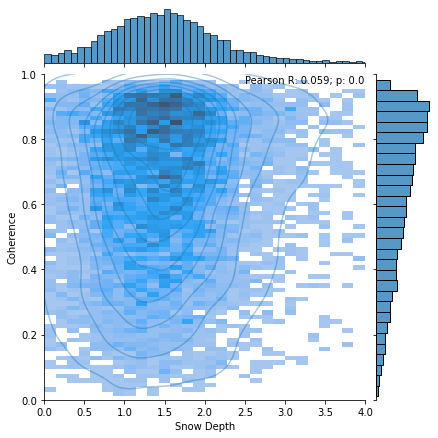

In [ ]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = sds[::50], y = cors[::50], kind = 'hist', bins = 70, ylim = (0,1), xlim = (0, 4))
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [2.5,0.97])
g.ax_joint.set_xlabel('Snow Depth')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/snow-depth', 'all-tree-inc-sd-cor.png'))